In [1]:
!pip install pgmpy

     |████████████████████████████████| 1.9 MB 8.8 MB/s 
     |████████████████████████████████| 1.9 MB 16.6 MB/s 
     |████████████████████████████████| 9.8 MB 5.2 MB/s 
     |████████████████████████████████| 233 kB 38.6 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [127]:
# imports

from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import BicScore
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
import networkx as nx
from pgmpy.inference import VariableElimination, ApproxInference
import matplotlib.pyplot as plt
from pgmpy.inference import ApproxInference

# Building the net
As first thing, we start by imposing an order on the list of attributes.The main idea is to follow a causal-relation order (so that causes precede effect) and to give a higher position in the order to attributes that should be less related to the problem at hand. Infact, we ordered first personal information about the individual, then information about is job and finally about its physical possessions and credit-card-releated information.

In [3]:
ordered_list_of_attr = ["Gender", "Age", "Family_status", "Num_family", "Education_type", "Income_type", "Unemployed", "Total_income", "Own_property", "Own_car", "Account_length", "Target"]

In [4]:
# Including dataset
df = pd.read_csv("data/processed.csv")
print(df.shape)
df.head()


(9709, 12)


,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
0,1,1,1,0,2,1y-2y,high,30-39,Working,Higher education,Civil marriage,1
1,1,1,1,0,2,2y-3y,low,50-59,Working,Secondary / secondary special,Married,0
2,0,0,1,0,1,<1y,high,50-59,Commercial associate,Secondary / secondary special,Single / not married,0
3,0,0,1,1,1,1y-2y,high,60>=,Pensioner,Higher education,Separated,0
4,1,1,1,0,2,<1y,high,40-49,Working,Higher education,Married,0


Then, driven by logic correlations and actual chi-square values computed on pairs of attributes, a hand-crafted net structure is built. An edge is inserted in the net if the two attributes can trivially be associated (e.g. <code>Family_status</code> influences obviously <code>Num_family</code>) or if the logarithm of the p value between the two is highly low (e.g. <code>Gender</code> -> <code>Own_car</code>). We also tried to keep the model fairly simple by deleting direct edges between attributes without a good dependency score and a easly direct understandable relation (e.g. <code>Num_family</code> -> <code>Income_type</code>)

In [ ]:
# chi^{2} test on pairs of columns, done in order to find the unconditioned dependence between the columns
cols = df.columns
p_values = np.zeros((len(cols), len(cols)))
for first_index, first_col_val in enumerate(cols): 
    for second_index, second_col_val in enumerate(cols):
        if first_index != second_index:
            (chi, p_value, dof) = chi_square(first_col_val, second_col_val, [], df, False)
            p_values[first_index, second_index] = p_value

display(pd.DataFrame(p_values, columns=cols, index=cols).apply(np.log)) 


,Gender,Own_car,Own_property,Unemployed,Num_family,Account_length,Total_income,Age,Income_type,Education_type,Family_status,Target
Gender,-inf,-616.245837,-17.096983,-140.816843,-34.306838,-2.642767,-251.917081,-135.953926,-156.408439,-2.182859,-119.955992,-1.916548
Own_car,-616.245837,-inf,-1.120036,-105.255566,-115.074168,-4.957653,-231.183178,-94.975367,-102.104702,-45.296526,-120.785831,-0.646807
Own_property,-17.096983,-1.120036,-inf,-38.607448,-0.942559,-1.855561,-1.720504,-75.401218,-34.515093,-2.647412,-6.636110,-5.121073
Unemployed,-140.816843,-105.255566,-38.607448,-inf,-284.349571,-1.880717,-185.514546,-inf,-inf,-95.578866,-222.627612,-4.156378
Num_family,-34.306838,-115.074168,-0.942559,-284.349571,-inf,-6.483826,-4.083536,-inf,-263.218627,-8.488100,-inf,-0.488970
Account_length,-2.642767,-4.957653,-1.855561,-1.880717,-6.483826,-inf,-3.403564,-44.705565,-5.788770,-0.243947,-15.158806,-27.701160
Total_income,-251.917081,-231.183178,-1.720504,-185.514546,-4.083536,-3.403564,-inf,-134.040988,-248.902894,-225.978093,-10.546587,-0.634457
Age,-135.953926,-94.975367,-75.401218,-inf,-inf,-44.705565,-134.040988,-inf,-inf,-200.761365,-494.049234,-5.911174
Income_type,-156.408439,-102.104702,-34.515093,-inf,-263.218627,-5.788770,-248.902894,-inf,-inf,-164.712017,-203.435712,-0.744493
Education_type,-2.182859,-45.296526,-2.647412,-95.578866,-8.488100,-0.243947,-225.978093,-200.761365,-164.712017,-inf,-37.841776,-2.266519


In [354]:
# list of arcs which shape the model, partly did by hand after doing some considerations and confirmed by chi^{2} tests.
# this will be fed to the hill-climbing method as a starting point to obtain a different network. The objective is to 
# increase the BIC score by keeping a network that is shaped by our personal semantic choices. 
edges = [("Gender", "Own_car"),
         ("Gender", "Total_income"),
         ("Age", "Education_type"),
         ("Age", "Income_type"),
         ("Age", "Unemployed"),
         ("Age", "Family_status"),
         ("Age", "Account_length"),
         ("Family_status", "Unemployed"),
         ("Family_status", "Own_car"),
         ("Family_status", "Num_family"),
         ("Num_family", "Target"),
         ("Education_type", "Income_type"),
         ("Income_type", "Unemployed"),
         ("Income_type", "Own_property"),
         ("Unemployed", "Total_income"),
         ("Total_income", "Own_car"),
         ("Own_property", "Target"),
         ("Account_length", "Target"),
]
bic_score = BicScore(df)
hand_net = BayesianNetwork(edges)
print("Number of edges:")
print(len(edges))

Number of edges:
18


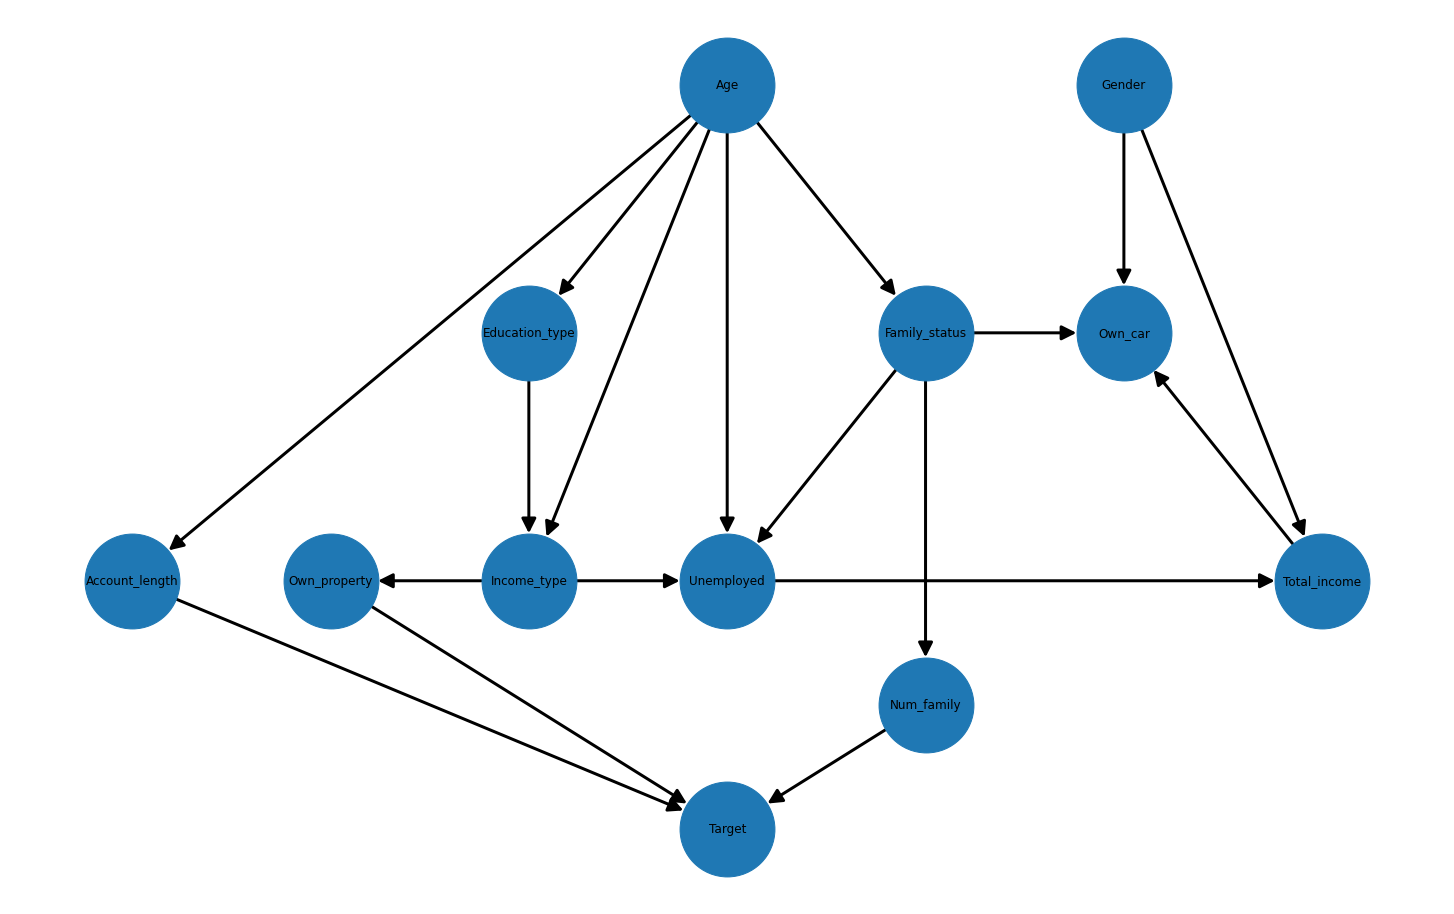

In [355]:
plt.figure(figsize=(20,12.5))
pos={"Gender":(5,5),
"Age":(3,5),
"Total_income":(6,3),
"Income_type":(2,3),
"Education_type":(2,4),
"Num_family":(4,2.5),
"Account_length":(0,3),
"Own_property":(1,3),
"Unemployed":(3,3),
"Own_car":(5,4),
"Family_status":(4,4),
"Target":(3,2),}
nx.draw(hand_net,pos=pos, with_labels=True, node_size=9000, width=3, arrowsize=30 )

Then we try to improve our net by running the hillclimb algorithm proposed by pgmy. It performs a heuristic search by [spiegare l'algoritmo]
In order to have a reference net, we apply simply the algorithm without doing any tuning, except by limiting the number of maximum parents. This limitation avoids nets that are too complex.

In [308]:
hillclimbmodel_orig = hillclimbest.estimate(scoring_method=bic_score, max_iter=100, max_indegree=3)


 18%|█▊        | 18/100 [00:00<00:00, 160.69it/s]


Number of edges:
18
Removed Edges:
{('Education_type', 'Income_type'), ('Family_status', 'Unemployed'), ('Family_status', 'Num_family'), ('Unemployed', 'Total_income'), ('Income_type', 'Own_property'), ('Own_property', 'Target'), ('Age', 'Income_type'), ('Num_family', 'Target'), ('Age', 'Unemployed'), ('Age', 'Education_type'), ('Family_status', 'Own_car'), ('Age', 'Account_length')}
Added_edges:
{('Num_family', 'Family_status'), ('Age', 'Num_family'), ('Age', 'Own_property'), ('Total_income', 'Education_type'), ('Total_income', 'Income_type'), ('Gender', 'Income_type'), ('Gender', 'Num_family'), ('Target', 'Unemployed'), ('Unemployed', 'Education_type'), ('Num_family', 'Own_car'), ('Unemployed', 'Age'), ('Gender', 'Age')}


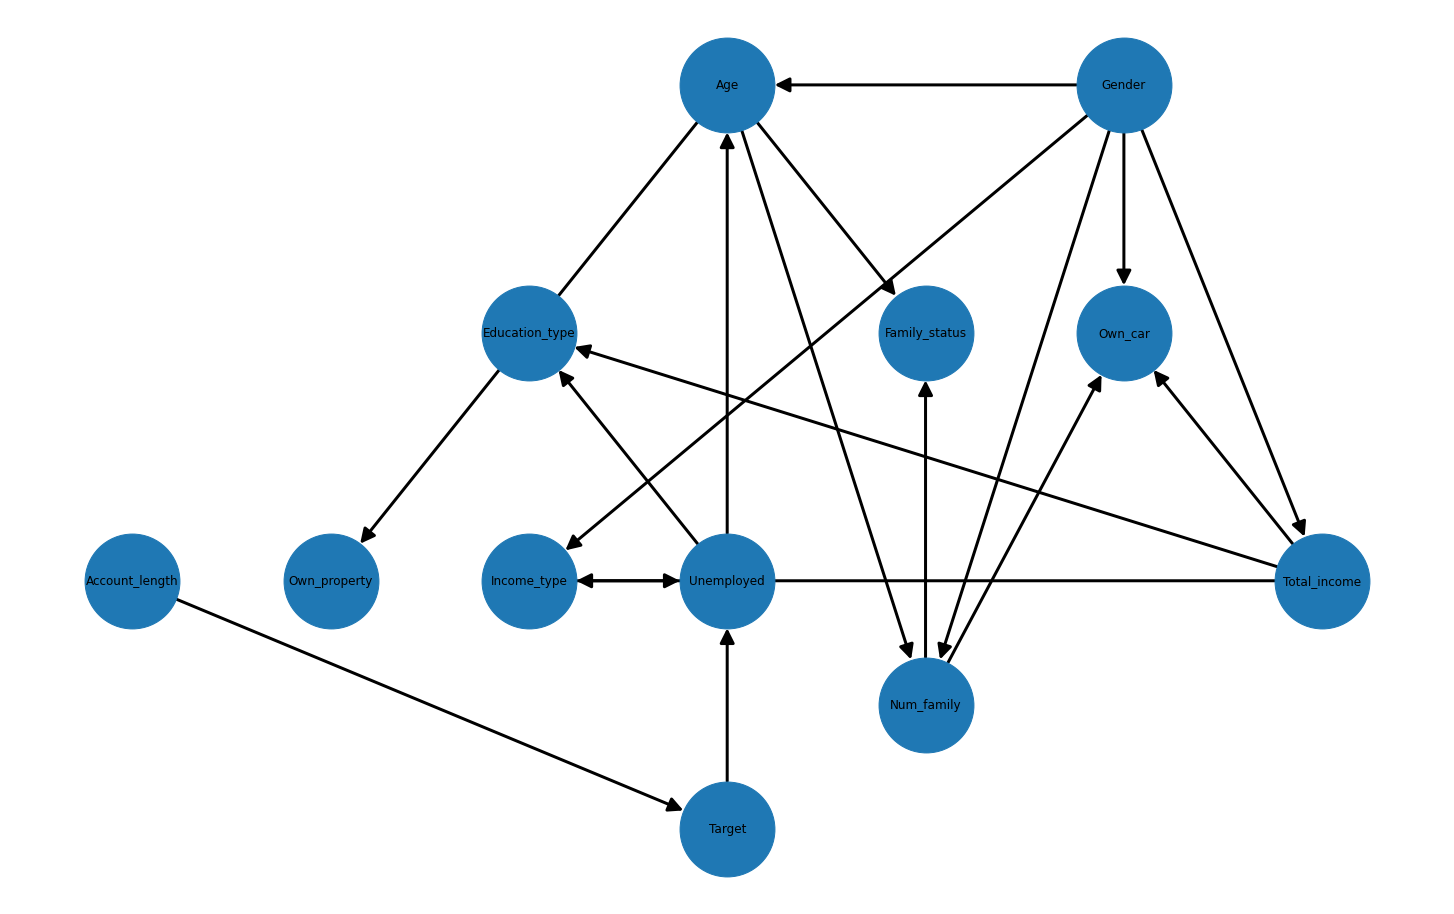

In [356]:
plt.figure(figsize=(20,12.5))
nx.draw(hillclimbmodel_orig,pos=pos, with_labels=True, node_size=9000, width=3, arrowsize=30 )
hillclimb_orig = BayesianNetwork(hillclimbmodel_orig)
print("Number of edges:")
print(len(hillclimbmodel_orig.edges))
print("Removed Edges:")
print(edges-hillclimbmodel_orig.edges)
print("Added_edges:")
print(hillclimbmodel_orig.edges-edges)


In order to provide an alternative to our net that sticks more on the relations that may emerge from the dataset, the method will start from our designed network and will try to add or remove the edges in order to optimize the BIC score of the net. In doing so, it will still consider the causal-order we imposed, in order to avoid relation that are too strange to interpret.

In [330]:
black_list = []
for i in range(len(ordered_list_of_attr)):
    for j in range(0, i):
        black_list.append((ordered_list_of_attr[i],ordered_list_of_attr[j]))


hillclimbest = HillClimbSearch(df)
start_dag = DAG()
start_dag.add_edges_from(ebunch=edges)
hillclimbmodel = hillclimbest.estimate(scoring_method=bic_score,start_dag=start_dag, black_list=black_list, max_iter=100, max_indegree=3)
hillclimb_net = BayesianNetwork(hillclimbmodel.edges)
print("Number of edges:")
print(len(hillclimbmodel.edges))
print("Removed Edges:")
print(edges-hillclimbmodel.edges)
print("Added_edges:")
print(hillclimbmodel.edges-edges)


 12%|█▏        | 12/100 [00:01<00:12,  6.80it/s]
BIC Score:
-93861.51219067867
Number of edges:
18
Removed Edges:
{('Education_type', 'Income_type'), ('Family_status', 'Unemployed'), ('Own_property', 'Target'), ('Num_family', 'Target'), ('Age', 'Unemployed'), ('Family_status', 'Own_car')}
Added_edges:
{('Gender', 'Family_status'), ('Gender', 'Income_type'), ('Education_type', 'Total_income'), ('Num_family', 'Own_car'), ('Age', 'Num_family'), ('Gender', 'Age')}


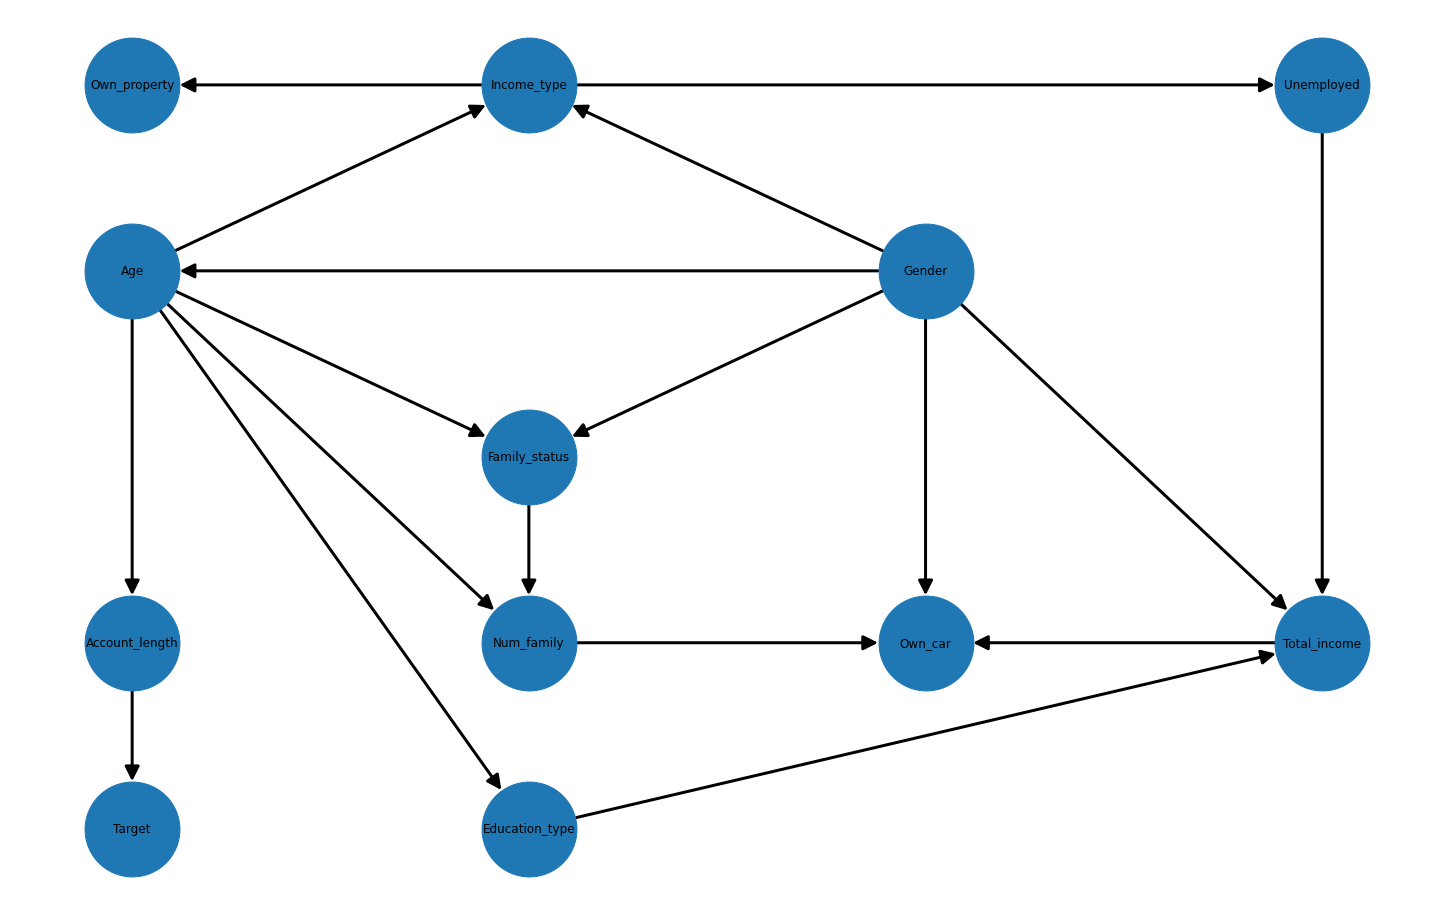

In [358]:
plt.figure(figsize=(20,12.5))
pos_hc = pos.copy()
pos_hc["Num_family"] =(4,3)
pos_hc["Total_income"] =(6,3)
pos_hc["Income_type"] =(4,6)
pos_hc["Own_property"] =(3,6)
pos_hc["Own_car"] =(5,3)
pos_hc["Unemployed"] =(6,6)
pos_hc["Education_type"] = (4,2)
pos_hc["Target"] = (3,2)
pos_hc["Account_length"] = (3,3)
nx.draw(hillclimbmodel,pos=pos_hc, with_labels=True, node_size=9000, width=3, arrowsize=30 )


We will then compare accuracy and complexity of both models, by taking into account the number of parameter stored and the distance of the inferred probabilities from the original ones (relative frequencies).
As for first step, the Conditional Probability Tables (CPTs) for each net will be obtained from the data by the use of an estimator. The most simple and naive would be the Maximum likelihood estimator, which would estimate the relative frequencies for each value of a variable given a specific configuration of the parents. In this case, however, our dataset may be missing some specific configurations that would make probabilities drop to 0 (e.g. P(Education_type = "Academic degree"|Age = "$\lt$30")=0). In order to avoid this, the Bayesian Estimator (implemented by pgmpy) is used. This estimator allows different kind of smoothing by defining a prior in terms of pseudo-counts for each state of variable and combination of parents.

In [334]:
# by default, nets are fitted with MLE
hand_net.fit(df)

# show variables with missing values
print("The following variables may be influenced by missing datapoints:")
for var in ordered_list_of_attr:
    if 0 in hand_net.get_cpds(var).get_values():
        print(var)

ve_infer = VariableElimination(hand_net)
print("\nAn example: P(Education_type | Age = <30 )")
print(ve_infer.query(["Education_type"], evidence={"Age":"<30"} ))


The following variables may be influenced by missing datapoints:
Education_type
Income_type
Unemployed
Own_car

An example: P(Education_type | Age = <30 )
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]+-----------------------------------------------+-----------------------+
| Education_type                                |   phi(Education_type) |
+===============================================+=======================+
| Education_type(Academic degree)               |                0.0000 |
+-----------------------------------------------+-----------------------+
| Education_type(Higher education)              |                0.3126 |
+-----------------------------------------------+-----------------------+
| Education_type(Incomplete higher)             |                0.1052 |
+-----------------------------------------------+-----------------------+
| Education_type(Lower secondary)               |                0.0081 |
+------------------------------------

Since our concern is only about missing values and we do not want to change the ratios of the prior, we will add the same quantity of samples to each configuration, so applying a laplace smoothing with alpha = 5. The value of alpha seems reasonable, considering the dimension of the dataset and that if we add a single pseudo-count, probabilities still may be low.

In [359]:
hand_net.fit(df, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=5)

ve_infer = VariableElimination(hand_net)
print("\nAn example: P(Education_type | Age = <30 )")
print(ve_infer.query(["Education_type"], evidence={"Age":"<30"}))

for var in ordered_list_of_attr:
    if 0 in hand_net.get_cpds(var).get_values():
        print(var)


An example: P(Education_type | Age = <30 )
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]+-----------------------------------------------+-----------------------+
| Education_type                                |   phi(Education_type) |
+===============================================+=======================+
| Education_type(Academic degree)               |                0.0036 |
+-----------------------------------------------+-----------------------+
| Education_type(Higher education)              |                0.3105 |
+-----------------------------------------------+-----------------------+
| Education_type(Incomplete higher)             |                0.1069 |
+-----------------------------------------------+-----------------------+
| Education_type(Lower secondary)               |                0.0116 |
+-----------------------------------------------+-----------------------+
| Education_type(Secondary / secondary special) |                0.5673 |


In [361]:
hillclimb_orig.fit(df, estimator=BayesianEstimator, prior_type="dirichlet", pseudo_counts=5)

In [362]:
get_num_parameters = lambda model: sum([len(cpd.get_values().ravel()) for cpd in model.get_cpds()])

print("Number of parameters in handmade network: {}".format(get_num_parameters(hand_net)))
print("Number of parameters in hillclimb baseline network: {}".format(get_num_parameters(hillclimb_orig)))
print("Number of parameters in hillclimb refined network: {}".format(get_num_parameters(hillclimb_net)))


# N.B. the documentation for bic_score asserts that a model with a higher score fits the data better,
# this is the opposite behavior with respect to what is described by the wikipedia page (source: help(bic_score))
print("Bic score for handmade network: {}".format(bic_score.score(hand_net)))
print("Bic score for hillclimb baseline network: {}".format(bic_score.score(hillclimb_orig)))
print("Bic score for hillclimb refined network: {}".format(bic_score.score(hillclimb_net)))

Number of parameters in handmade network: 618
Number of parameters in hillclimb baseline network: 318
Number of parameters in hillclimb refined network: 393
Bic score for handmade network: -95924.9377778521
Bic score for hillclimb baseline network: -93662.09117179617
Bic score for hillclimb refined network: -93861.51219067867


The "ApproxInference" class of pgmpy is used to compute approximations of posterior distributions through rejection sampling over a model. In particular, in order to compute a query we need the structure of the network, the variables on which the probability distribution must be calculated, the observed evidence and the number of samples to be performed. The principle is really simple: we sample from the data n_samples examples that satisfy the evidence, then we observe the outcome for each value of the queried variable and we normalize the results with respect to n_samples.
The following block of code shows the performance of this method with an increasing number of samples.
N.B. we can oversample the data.


In [262]:
num_examples = df.shape[0]
approx_infer = ApproxInference(hand_net)
n_samples_attempts = [10, 100, 1000, num_examples, 10000]
for ns in n_samples_attempts:
    print(f"An example: P(Education_type | Age = <30 ), performing {ns} samples\n")
    print(str(approx_infer.query(["Education_type"], evidence={"Age":"<30"}, n_samples = ns, show_progress = False)) + "\n")

An example: P(Education_type | Age = <30 ), performing 10 samples

+-----------------------------------------------+-----------------------+
| Education_type                                |   phi(Education_type) |
+===============================================+=======================+
| Education_type(Higher education)              |                0.6000 |
+-----------------------------------------------+-----------------------+
| Education_type(Incomplete higher)             |                0.2000 |
+-----------------------------------------------+-----------------------+
| Education_type(Secondary / secondary special) |                0.2000 |
+-----------------------------------------------+-----------------------+

An example: P(Education_type | Age = <30 ), performing 100 samples

+-----------------------------------------------+-----------------------+
| Education_type                                |   phi(Education_type) |
+===============================================+=

In [364]:
# TOFIX

from pgmpy.sampling import BayesianModelSampling
from pgmpy.factors.discrete import State
#print(pd.unique(df["Income_type"]))

def put_in_buckets(sample_table, var_to_query, weight_column_name):
    dict_of_weights = {}
    for index, elem in enumerate(sample_table[var_to_query]):
        #dict_of_weights[(var_to_query, elem)] += sample_table[weight_column_name]
        if dict_of_weights.get(tuple((var_to_query, elem))) != None:
            upd_val = sample_table[weight_column_name][index] + dict_of_weights.get((var_to_query, elem))
        else:
            upd_val = sample_table[weight_column_name][index]
        dict_of_weights.update({(var_to_query, elem): upd_val})
    return dict_of_weights

def normalize_dict(dict_to_normalize, normalization_factor):
    for key in dict_to_normalize.keys():
        upd_val = dict_to_normalize[key] / normalization_factor
        dict_to_normalize.update({key:upd_val})
    return dict_to_normalize

num_examples = df.shape[0]
var_to_query = ["Education_type"] #il problema è che sono una ciola
evidence = [State("Age", "<30"), State("Income_type", "Working")]
weight_column_name = "_weight"
lw_sampler = BayesianModelSampling(hand_net) #the function to be called to perform likelihood_weighted_sampling
n_samples_attempts = [10, 100, 1000, num_examples, 10000]
for ns in n_samples_attempts:
    print(f"An example: P(Education_type | Age = <30 ), performing {ns} samples\n")
    sample_table = lw_sampler.likelihood_weighted_sample(evidence, size = ns)
    total_sum_of_weights = sum(sample_table[weight_column_name])#needed to normalize
    dict_of_weights = put_in_buckets(sample_table, var_to_query, weight_column_name)
    dict_of_weights = normalize_dict(dict_of_weights, total_sum_of_weights)



An example: P(Education_type | Age = <30 ), performing 10 samples

Generating for node: Own_car: 100%|██████████| 12/12 [00:00<00:00, 76.02it/s]


TypeError: unhashable type: 'list'

In [ ]:
ve_infer_hand = VariableElimination(hand_net)
ve_infer_hill = VariableElimination(hillclimb_net)

query_var = ["Age"]
query_ev = {"Own_car": 0}

print(ve_infer_hand.query(query_var, query_ev))
print(ve_infer_hill.query(query_var, query_ev))
print()

Eliminating: Education_type: 100%|██████████| 6/6 [00:00<00:00, 42.73it/s]
+------------+------------+
| Age        |   phi(Age) |
+============+============+
| Age(30-39) |     0.2749 |
+------------+------------+
| Age(40-49) |     0.2478 |
+------------+------------+
| Age(50-59) |     0.2252 |
+------------+------------+
| Age(60>=)  |     0.1105 |
+------------+------------+
| Age(<30)   |     0.1416 |
+------------+------------+
Eliminating: Gender: 100%|██████████| 7/7 [00:00<00:00, 204.94it/s]+------------+------------+
| Age        |   phi(Age) |
+============+============+
| Age(30-39) |     0.2629 |
+------------+------------+
| Age(40-49) |     0.2463 |
+------------+------------+
| Age(50-59) |     0.2403 |
+------------+------------+
| Age(60>=)  |     0.1207 |
+------------+------------+
| Age(<30)   |     0.1298 |
+------------+------------+




In [21]:
import itertools

def rel_freq(df, query_vars, query_evs):
    df_evs = df.loc[(df[list(query_evs)] == pd.Series(query_evs)).all(axis=1)]
    num_samples = len(df_evs)

    unique_list = [tuple(pd.unique(df[var])) for var in query_vars]
    combinations = list(itertools.product(*unique_list))
    
    cpds = []
    for c in combinations:
        vars_dict = dict(zip(query_vars, c))
        cpds.append(len(df_evs.loc[(df_evs[query_vars] == pd.Series(vars_dict)).all(axis=1)])/num_samples)
    
    return cpds

print(rel_freq(df, ["Age"], {"Own_car": 1, "Num_family":"1"}))

[0.21739130434782608, 0.20434782608695654, 0.07173913043478261, 0.1782608695652174, 0.3282608695652174]


In [316]:
def display_active_trails(network, target_node, given_nodes, nodes_position=pos):
    active_trail = network.active_trail_nodes(target_node, given_nodes)[target_node]

    nodes_colors = []
    for node in network.nodes():
        if node == target_node:
            nodes_colors.append("tab:blue")
        elif node in active_trail:
            nodes_colors.append("tab:green")
        elif node in given_nodes:
            nodes_colors.append("pink")
        else:
            nodes_colors.append("tab:red")

    edges_colors = []
    edges_weights = []
    for (u, v) in network.edges:
        if u in active_trail and v in active_trail:
            edges_colors.append("tab:green")
            edges_weights.append(4)
        else:
            edges_colors.append("tab:red")
            edges_weights.append(2)

    plt.figure(figsize=(20,12.5))
    nx.draw(network, nodes_position, width=edges_weights,
            node_color=nodes_colors, edge_color=edges_colors,
            with_labels=True, node_size=9000, arrowsize=20)


def visualize_vstructure(network):
    nodes_to_color = []
    list_nodes_right = [v for (u, v) in network.edges]
    for index, (u, v) in enumerate(network.edges):
        list_nodes_right.pop(0)
        if v in list_nodes_right:
            nodes_to_color.append(v)
    
    nodes_colors = []
    for node in network.nodes():
        nodes_colors.append("tab:green" if node in nodes_to_color else "tab:blue")

    plt.figure(figsize=(20,12.5))
    nx.draw(network, pos_hc,
            node_color=nodes_colors,
            with_labels=True, node_size=9000, arrowsize=20)

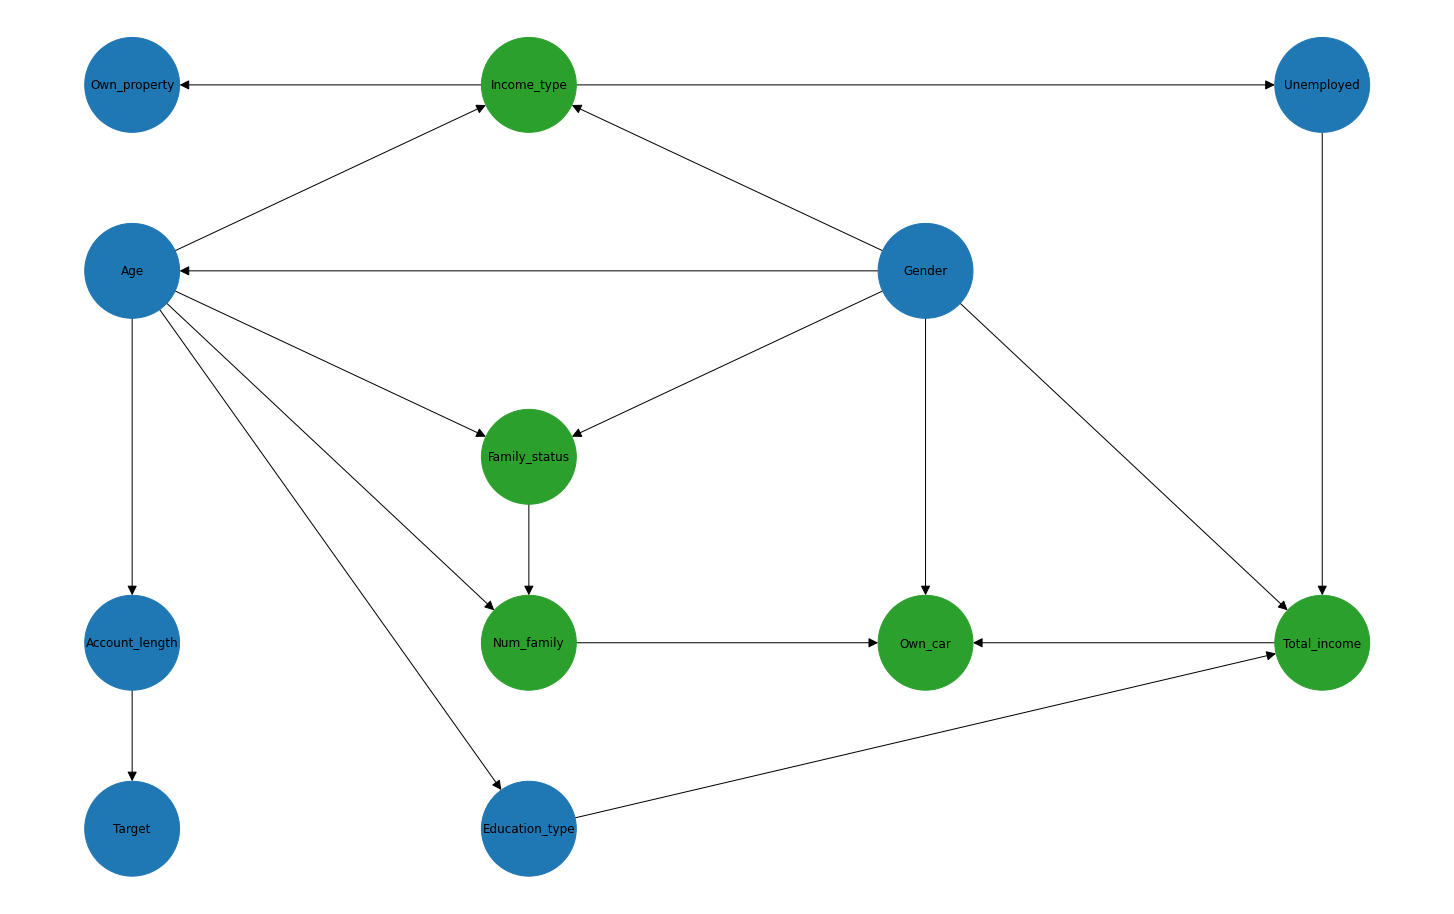

In [317]:
visualize_vstructure(hillclimbmodel)

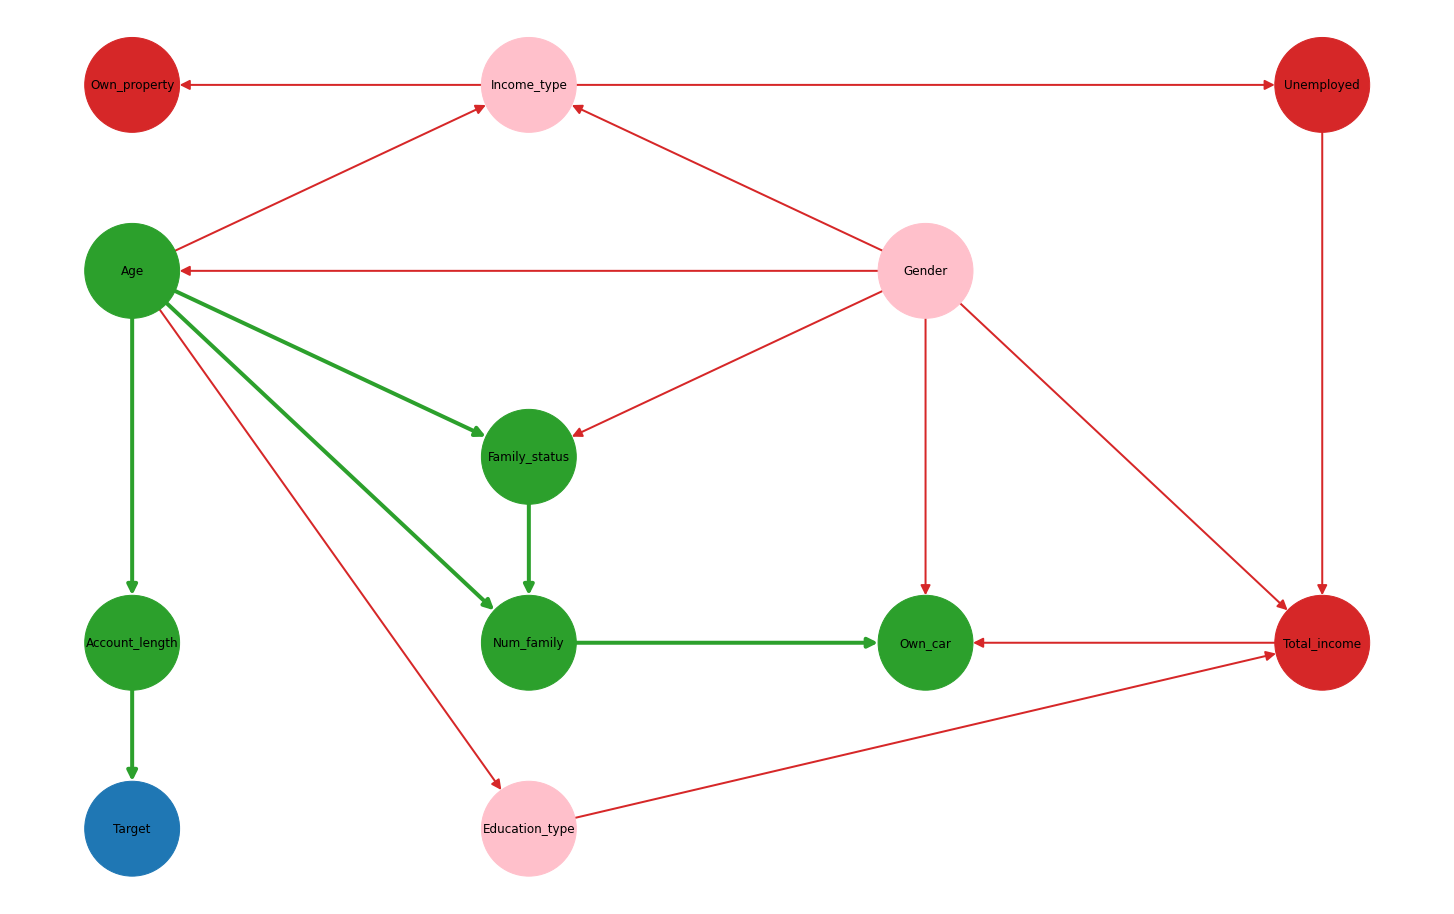

In [297]:
target_node = "Target"
given_nodes = ["Income_type", "Education_type", "Gender"]
display_active_trails(hillclimbmodel, target_node, given_nodes, pos_hc)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=03282642-4d6b-431b-a45f-9f21a6236fff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>